In [ ]:
!pip install dgl


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 16.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylin

In [ ]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl.data
dataset = dgl.data.CoraGraphDataset()
g = dataset[0]

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


/root/.dgl/cora_v2.zip:   0%|          | 0.00/132k [00:00<?, ?B/s]

Extracting file to /root/.dgl/cora_v2_d697a464
Finished data loading and preprocessing.
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.


In [ ]:
from dgl.nn import GraphConv
class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h
# Create the model with given dimensions
model = GCN(g.ndata['feat'].shape[1], 16, dataset.num_classes)

In epoch 0, loss: 1.946, val acc: 0.242 (best 0.242), test acc: 0.224 (best 0.224)
In epoch 5, loss: 1.904, val acc: 0.494 (best 0.494), test acc: 0.512 (best 0.512)
In epoch 10, loss: 1.835, val acc: 0.564 (best 0.564), test acc: 0.577 (best 0.577)
In epoch 15, loss: 1.742, val acc: 0.644 (best 0.644), test acc: 0.665 (best 0.665)
In epoch 20, loss: 1.626, val acc: 0.686 (best 0.686), test acc: 0.694 (best 0.694)
In epoch 25, loss: 1.488, val acc: 0.692 (best 0.694), test acc: 0.707 (best 0.700)
In epoch 30, loss: 1.334, val acc: 0.704 (best 0.704), test acc: 0.727 (best 0.727)
In epoch 35, loss: 1.169, val acc: 0.722 (best 0.722), test acc: 0.745 (best 0.745)
In epoch 40, loss: 1.001, val acc: 0.720 (best 0.722), test acc: 0.748 (best 0.745)
In epoch 45, loss: 0.840, val acc: 0.730 (best 0.730), test acc: 0.760 (best 0.760)
In epoch 50, loss: 0.693, val acc: 0.738 (best 0.740), test acc: 0.761 (best 0.760)
In epoch 55, loss: 0.564, val acc: 0.750 (best 0.750), test acc: 0.761 (best 0

Text(0, 0.5, 'Accuracy')

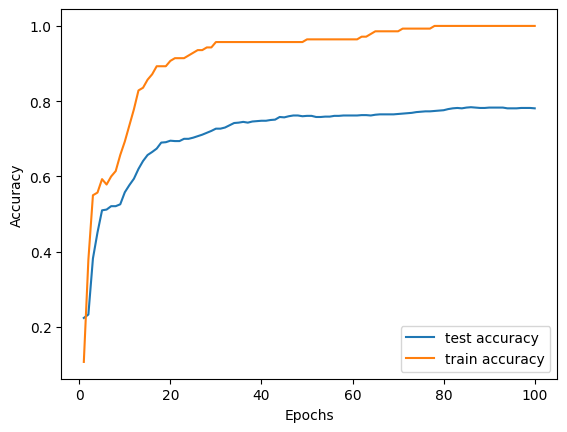

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def train(g, model):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    best_val_acc = 0
    best_test_acc = 0
    train_accuracy_plot = []
    test_accuracy_plot = []
    features = g.ndata['feat']
    labels = g.ndata['label']
    train_mask = g.ndata['train_mask']
    val_mask = g.ndata['val_mask']
    test_mask = g.ndata['test_mask']
    for e in range(100):
        # Forward
        logits = model(g, features)

        # Compute prediction
        pred = logits.argmax(1)

        # Compute loss
        loss_train = F.cross_entropy(logits[train_mask], labels[train_mask])
        loss_train_plot = F.cross_entropy(logits[train_mask], labels[train_mask])

        loss_test = F.cross_entropy(logits[test_mask],labels[test_mask])
        # Compute accuracy on training/validation/test
        train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
        val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
        test_acc = (pred[test_mask] == labels[test_mask]).float().mean()

        train_accuracy_plot.append(train_acc)
        test_accuracy_plot.append(test_acc)

        # Save the best validation accuracy and the corresponding test accuracy.
        if best_val_acc < val_acc:
            best_val_acc = val_acc
            best_test_acc = test_acc

        # Backward
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        if e % 5 == 0:
            print('In epoch {}, loss: {:.3f}, val acc: {:.3f} (best {:.3f}), test acc: {:.3f} (best {:.3f})'.format(
                e, loss_train, val_acc, best_val_acc, test_acc, best_test_acc))
    return test_accuracy_plot, train_accuracy_plot
model = GCN(g.ndata['feat'].shape[1], 16, dataset.num_classes)
test_accuracy_plot, train_accuracy_plot = train(g, model)
epochs = np.linspace(1,100,100)
plt.plot(epochs, test_accuracy_plot, epochs, train_accuracy_plot)
plt.legend(['test accuracy','train accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

torch.Size([])
